In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
import pickle as pkl
import os
import time
from nltk.tokenize import word_tokenize
from gensim.models.doc2vec import Doc2Vec
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
class_mapping = {}
with open('dbpedia/dbpedia_csv/classes.txt') as txt_file:
    line_num = 1
    for line in txt_file:
        class_mapping[line_num-1] = line.strip()
        line_num+=1
        
print(class_mapping)

FileNotFoundError: [Errno 2] No such file or directory: 'dbpedia/dbpedia_csv/classes.txt'

In [3]:
def plot_loss_acc(loss_acc):
    plt.plot(loss_acc['acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

    plt.plot(loss_acc['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    return

def plot_learning(lossAccPath):
    if os.path.exists(lossAccPath):
        loss_acc = pkl.load(open(lossAccPath, 'rb'))
    plot_loss_acc(loss_acc)
    return

In [7]:
plot_learning('Sequential_3loss_acc')

UnboundLocalError: local variable 'loss_acc' referenced before assignment

In [4]:
class WordSequenceDataGenerator(keras.utils.Sequence):
    def __init__(self, list_IDs, batch_size=32,
                 n_classes=14, shuffle=True):
        'Initialization'
        self.dim = (300,)
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate index of the batch
        indexes = self.indexes[index:(index+1)]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, list_IDs_temp):
        
        X = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size), dtype = int)
        for item in list_IDs_temp:
            Xarray = pkl.load(open('dbpedia/Training/'+item, 'rb'))
        for i, row in enumerate(Xarray[1]):
            X[i,] = Doc2Vec_model.infer_vector(row)
            y[i] = Xarray[0]-1
            
        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

# Train Doc2Vec

In [ ]:
Doc2Vec_train_data = list(pd.read_csv('dbpedia/dbpedia_csv/train.csv', header = -1,
                                      names = ['ClassIndex', 'Title', 'Content'])['Content'])
tagged_Doc2Vec_train_data = [TaggedDocument(words = word_tokenize(_d.lower()),
                                            tags = [i]) for i, _d in enumerate(Doc2Vec_train_data)]
del Doc2Vec_train_data

start = time.time()
max_epochs = 10
vector_size = 300

model = Doc2Vec(vector_size = vector_size, min_count = 2, workers = 4, epochs = max_epochs)
model_build_time = time.time()
print("Built model in {}".format(model_build_time-start))

model.build_vocab(tagged_Doc2Vec_train_data)
build_vocab_time = time.time()
print("Built vocab in {}".format(build_vocab_time-model_build_time))

model.train(tagged_Doc2Vec_train_data, total_examples=model.corpus_count, epochs = model.epochs)
end = time.time()
print("Trained model in {}".format(end-build_vocab_time))
model.save("Doc2Vec.model")

## Load Trained Doc2Vec Model

In [14]:
Doc2Vec_model = Doc2Vec.load("Doc2Vec.model")
Doc2Vec_model.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
partition, labels = pkl.load(open('dbpedia/Training/Metadata', 'rb'))
for key in labels.keys():
    labels[key] -= 1

In [6]:
params = {'batch_size':32, 'n_classes': 14, 'shuffle': True}
training_generator = WordSequenceDataGenerator(partition['train'], **params)
validation_generator = WordSequenceDataGenerator(partition['validation'], **params)

### Training

In [ ]:
model = keras.models.load_model('Sequential_3.hdf5')
# model = Sequential()
# model.add(Dense(128, activation = 'relu', input_dim = 300))
# model.add(Dense(128, activation = 'relu'))
# model.add(Dense(14, activation = 'softmax'))
# model.compile(optimizer = 'Nadam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.name = 'Sequential_3'
loss_acc_path = model.name+'loss_acc'
history = model.fit_generator(generator = training_generator, epochs = 5, validation_data = validation_generator, verbose = 1)
loss_acc = {}
if os.path.exists(loss_acc_path):
    loss_acc = pkl.load(open(loss_acc_path, 'rb'))
    loss_acc['acc'] = loss_acc['acc'] + history.history['acc']
    loss_acc['loss'] = loss_acc['loss'] + history.history['loss']
else:
    loss_acc['acc'] = history.history['acc']
    loss_acc['loss'] = history.history['loss']
pkl.dump(loss_acc,open(loss_acc_path, 'wb'))
model.save(model.name+'.hdf5')

### Testing

In [ ]:
model = keras.models.load_model('Sequential_3.hdf5')
Doc2Vec_model = Doc2Vec.load("Doc2Vec.model")
Doc2Vec_model.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [ ]:
start = time.time()
accuracies = {}
for label in os.listdir('dbpedia/Testing'):
    accuracies[label] = {}
    for sent_len in os.listdir('dbpedia/Testing/{}/'.format(label)):
        Xtest = np.empty((0,300))
        labels = []
        for file in os.listdir('dbpedia/Testing/{}/{}/'.format(label,sent_len)):
            sample = pkl.load(open('dbpedia/Testing/{}/{}/{}'.format(label,sent_len,file), 'rb'))
            labels.append(sample[0])
            Xtest = np.vstack((Xtest, Doc2Vec_model.infer_vector(sample[1])))
        result = model.predict(Xtest)
        result = np.argmax(result,axis = 1)+1
        accuracy = np.sum(result == labels)/len(labels)
        print('{}, sentence length: {}, Accuracy: {}'.format(label,sent_len,np.sum(result == labels)/len(labels)))
        accuracies[label][sent_len] = accuracy
        print('elapsed time: {}'.format((time.time()-start)/60))
pkl.dump(accuracies, open('dbpedia/Testing/Accuracy', 'wb'))

In [156]:
accs = pkl.load(open('dbpedia/Testing/Accuracy', 'rb'))

In [162]:
for key1 in accs.keys():
    for key2 in accs[key1].keys():
        print("{}:\tSentence length: {}\tAccuracy: {}".format(key1,key2,accs[key1][key2]))

Class1:	Sentence length: 1	Accuracy: 0.0006
Class1:	Sentence length: 10	Accuracy: 0.502408671216379
Class1:	Sentence length: 100	Accuracy: 0.8125
Class1:	Sentence length: 101	Accuracy: 0.9285714285714286
Class1:	Sentence length: 102	Accuracy: 0.7692307692307693
Class1:	Sentence length: 103	Accuracy: 0.6923076923076923
Class1:	Sentence length: 104	Accuracy: 0.8461538461538461
Class1:	Sentence length: 105	Accuracy: 0.7692307692307693
Class1:	Sentence length: 106	Accuracy: 0.8333333333333334
Class1:	Sentence length: 107	Accuracy: 0.8333333333333334
Class1:	Sentence length: 108	Accuracy: 0.8333333333333334
Class1:	Sentence length: 109	Accuracy: 0.8181818181818182
Class1:	Sentence length: 11	Accuracy: 0.5417253167102353
Class1:	Sentence length: 110	Accuracy: 0.9
Class1:	Sentence length: 111	Accuracy: 0.8888888888888888
Class1:	Sentence length: 112	Accuracy: 0.7777777777777778
Class1:	Sentence length: 113	Accuracy: 0.8888888888888888
Class1:	Sentence length: 114	Accuracy: 0.6666666666666666


Class2:	Sentence length: 12	Accuracy: 0.51103088648215
Class2:	Sentence length: 120	Accuracy: 0.8
Class2:	Sentence length: 121	Accuracy: 0.8
Class2:	Sentence length: 122	Accuracy: 0.75
Class2:	Sentence length: 123	Accuracy: 1.0
Class2:	Sentence length: 124	Accuracy: 1.0
Class2:	Sentence length: 125	Accuracy: 1.0
Class2:	Sentence length: 126	Accuracy: 0.6666666666666666
Class2:	Sentence length: 127	Accuracy: 1.0
Class2:	Sentence length: 128	Accuracy: 0.6666666666666666
Class2:	Sentence length: 129	Accuracy: 0.5
Class2:	Sentence length: 13	Accuracy: 0.5371152685576343
Class2:	Sentence length: 130	Accuracy: 0.5
Class2:	Sentence length: 131	Accuracy: 1.0
Class2:	Sentence length: 132	Accuracy: 0.5
Class2:	Sentence length: 133	Accuracy: 1.0
Class2:	Sentence length: 134	Accuracy: 0.5
Class2:	Sentence length: 135	Accuracy: 0.0
Class2:	Sentence length: 136	Accuracy: 1.0
Class2:	Sentence length: 137	Accuracy: 0.0
Class2:	Sentence length: 138	Accuracy: 1.0
Class2:	Sentence length: 139	Accuracy: 0

Class7:	Sentence length: 116	Accuracy: 0.6666666666666666
Class7:	Sentence length: 117	Accuracy: 0.5
Class7:	Sentence length: 118	Accuracy: 0.5
Class7:	Sentence length: 119	Accuracy: 0.5
Class7:	Sentence length: 12	Accuracy: 0.5584258324924319
Class7:	Sentence length: 120	Accuracy: 0.5
Class7:	Sentence length: 121	Accuracy: 0.5
Class7:	Sentence length: 122	Accuracy: 0.5
Class7:	Sentence length: 123	Accuracy: 1.0
Class7:	Sentence length: 124	Accuracy: 0.5
Class7:	Sentence length: 125	Accuracy: 0.5
Class7:	Sentence length: 126	Accuracy: 0.5
Class7:	Sentence length: 127	Accuracy: 0.5
Class7:	Sentence length: 128	Accuracy: 0.0
Class7:	Sentence length: 129	Accuracy: 0.0
Class7:	Sentence length: 13	Accuracy: 0.5955465587044534
Class7:	Sentence length: 130	Accuracy: 0.0
Class7:	Sentence length: 131	Accuracy: 0.0
Class7:	Sentence length: 132	Accuracy: 0.0
Class7:	Sentence length: 133	Accuracy: 0.0
Class7:	Sentence length: 134	Accuracy: 0.0
Class7:	Sentence length: 135	Accuracy: 0.0
Class7:	Sen

In [269]:
accuracies = pd.DataFrame([accs[key] for key in accs.keys()]).rename(index = class_mapping)
accuracies = accuracies.reindex(sorted(list(accuracies.columns), key = int), axis = 1).transpose()
accuracies['Total Accuracy'] = accuracies.sum(axis=1)/14
accuracies['Number of Words'] = accuracies.index.astype(int)
accuracies

,Company,EducationalInstitution,Artist,Athlete,OfficeHolder,MeanOfTransportation,Building,NaturalPlace,Village,Animal,Plant,Album,Film,WrittenWork,Total Accuracy,Number of Words
1,0.000600,0.000000,0.001200,0.000600,0.002000,0.001600,0.498800,0.000000,0.000000,0.006200,0.110800,0.588400,0.000000,0.000000,0.086443,1
2,0.027000,0.080600,0.257800,0.007600,0.067600,0.047400,0.676600,0.000600,0.000000,0.006200,0.157000,0.209800,0.009800,0.260000,0.129143,2
3,0.072400,0.111800,0.289200,0.016400,0.135400,0.092600,0.550400,0.006000,0.004000,0.014400,0.330200,0.204600,0.026000,0.316800,0.155014,3
4,0.152030,0.188000,0.375600,0.099020,0.266000,0.148000,0.393557,0.056645,0.260957,0.046409,0.392200,0.203400,0.142800,0.370600,0.221087,4
5,0.245846,0.392000,0.617123,0.186437,0.409600,0.214800,0.303922,0.089271,0.424455,0.096419,0.427800,0.246400,0.273600,0.410400,0.309862,5
6,0.326257,0.472000,0.637728,0.309662,0.527400,0.276800,0.320128,0.128703,0.524515,0.205123,0.503000,0.293600,0.480800,0.528200,0.395280,6
7,0.377079,0.656600,0.582717,0.443689,0.604805,0.309800,0.352411,0.121297,0.582983,0.250350,0.548400,0.361200,0.549600,0.685200,0.459009,7
8,0.416232,0.661261,0.601043,0.555222,0.662189,0.335667,0.366620,0.141797,0.615415,0.292634,0.599600,0.416000,0.574263,0.769878,0.500559,8
9,0.456387,0.657821,0.634988,0.638093,0.697390,0.362908,0.406244,0.168375,0.626528,0.310684,0.622925,0.456091,0.604762,0.836645,0.534274,9
10,0.502409,0.704872,0.693923,0.706578,0.732298,0.378812,0.443866,0.214199,0.627557,0.338344,0.655193,0.499497,0.626588,0.864615,0.570625,10


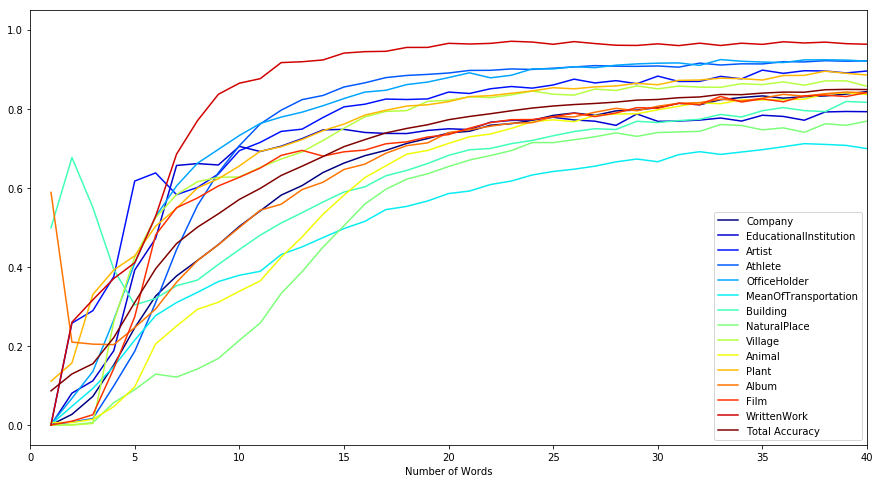

In [276]:
accuracies.plot(x ='Number of Words', figsize = (15,8), xlim=(0,40), colormap = 'jet')
plt.show()

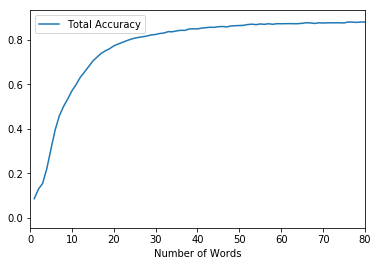

In [282]:
accuracies.plot(x = 'Number of Words', y = 'Total Accuracy', xlim=(0,80))
plt.show()